# 3D Data Cubes
In the tutorial we will visualyse 2D and 3D data sets in different coordinates (galactic and ecuatorial). 

In [1]:
# Library imports

In [2]:
from astropy.utils.data import download_file
from astropy.io import fits
import os
from spectral_cube import SpectralCube
from astropy import units as u
import astropy.coordinates as coord
from astroquery.esasky import ESASky
import astroquery
import numpy as np
from astropy.wcs import WCS
import aplpy
import matplotlib.pyplot as plt
%matplotlib inline

# Reading/Downloading HI data

HI data is form the HI4PI survey. 

In [4]:
'''
It checks working directory for data file.  If data is not present it downlowds it.  Data file is save as hi_data. 
cube: is the HI data array.
'''

if not os.path.isfile('TAN_C14.fits'):
    hi_datafile = download_file('http://cdsarc.u-strasbg.fr/vizier/ftp/cats/J/A+A/594/A116/CUBES/GAL/TAN/TAN_C14.fits',
                       cache=True)
else:
    hi_datafile = 'TAN_C14.fits'

hi_data = fits.open(hi_datafile)
cube = SpectralCube.read(hi_data)
hi_data.close()


In [5]:
'''
This prits the characteristics of the data cube. Dimension, coord system, units, value range.
'''
cube

SpectralCube with shape=(933, 277, 269) and unit=K:
 n_x:    269  type_x: GLON-TAN  unit_x: deg    range:   286.707162 deg:  320.913024 deg
 n_y:    277  type_y: GLAT-TAN  unit_y: deg    range:   -51.659734 deg:  -28.394756 deg
 n_s:    933  type_s: VRAD      unit_s: m / s  range:  -600207.218 m / s:  600409.133 m / s

# Reading/Downloading Infrared data

Infrared data is from Herschel

In [6]:
'''
Todo: Change 'result' to 'map'.
Opens and using astroquery the Herschel map of the SMC
result: is a table witht he availabe data around the SMC with 1 degree with the Herschel data.
'''

result = ESASky.query_region_maps('SMC', radius = 1*u.deg, missions = 'Herschel')
print(result)

TableList with 1 tables:
	'0:HERSCHEL' with 11 column(s) and 24 row(s) 


In [7]:
'''
Within result, we have one table called HERSCHEL. This Table has 11 columns of which filter is one. We are looking
for a particular observation which was taken with the 350micron filter. This observation was made in a paper that 
includes observations in 250 and 500 micron filters as well. Hence to identify the observations that we are after, 
we search for the observation with filters '250, 350, 500'. 

In order for that data to be accepted by the get_maps function, we need to convert the specific result to a TableList
That is what is done in the last statement.

filters: generates a table from 'result' that it will be filter at the corresponding wavelenghts.

'''

filters = result['HERSCHEL']['filter'].astype(str)

ind = np.array(['250, 350, 500' == s for s in filters], dtype = 'bool')

target_obs = astroquery.utils.TableList({"HERSCHEL":result['HERSCHEL'][np.array(ind, dtype='bool')]})

In [ ]:
'''
Here we download the data from the esac.esa.int website.

TODO: May be add if statement to check if the file exists.
'''

images = ESASky.get_maps(target_obs, cache=False)

Starting download of HERSCHEL data. (1 files)

In [75]:
'''
Here we select the 350micron filter from the downloaded data
'''

images['HERSCHEL'][0]['350'].info()

{'HERSCHEL': [{'250': [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x11ff50a58>, <astropy.io.fits.hdu.image.ImageHDU object at 0x12105bf60>, <astropy.io.fits.hdu.image.ImageHDU object at 0x121064f98>, <astropy.io.fits.hdu.image.ImageHDU object at 0x121069b38>, <astropy.io.fits.hdu.image.ImageHDU object at 0x12106fac8>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x121076748>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x12107c390>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x121001ba8>], '350': [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x11ff35588>, <astropy.io.fits.hdu.image.ImageHDU object at 0x12100dac8>, <astropy.io.fits.hdu.image.ImageHDU object at 0x121013c50>, <astropy.io.fits.hdu.image.ImageHDU object at 0x12101add8>, <astropy.io.fits.hdu.image.ImageHDU object at 0x121020780>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x121026400>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x12102d048>, <astropy.io.fits.hdu.table.BinTableHDU object at 

In [78]:
'''
Here we are grabing the WCS (World Coordinate System?) keywords from the header of the file, so that we can maniplulate
the coordinates of the pixels later.

Also here we are taking in the herschel image.

'''

w = WCS(images['HERSCHEL'][0]['350'][0])
herschel_imagehdu = images['HERSCHEL'][0]['350'][1]
print(w)

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 18.99666058287459  -71.828763749063185  
CRPIX : 1769.0  2527.0  
NAXIS : 0  0


INFO: Auto-setting vmin to -1.813e+00 [aplpy.core]
INFO: Auto-setting vmax to  2.659e+01 [aplpy.core]


/Users/DK/anaconda/envs/dk/lib/python3.6/site-packages/aplpy/normalize.py:115: RuntimeWarning: invalid value encountered in less
  negative = result < 0.


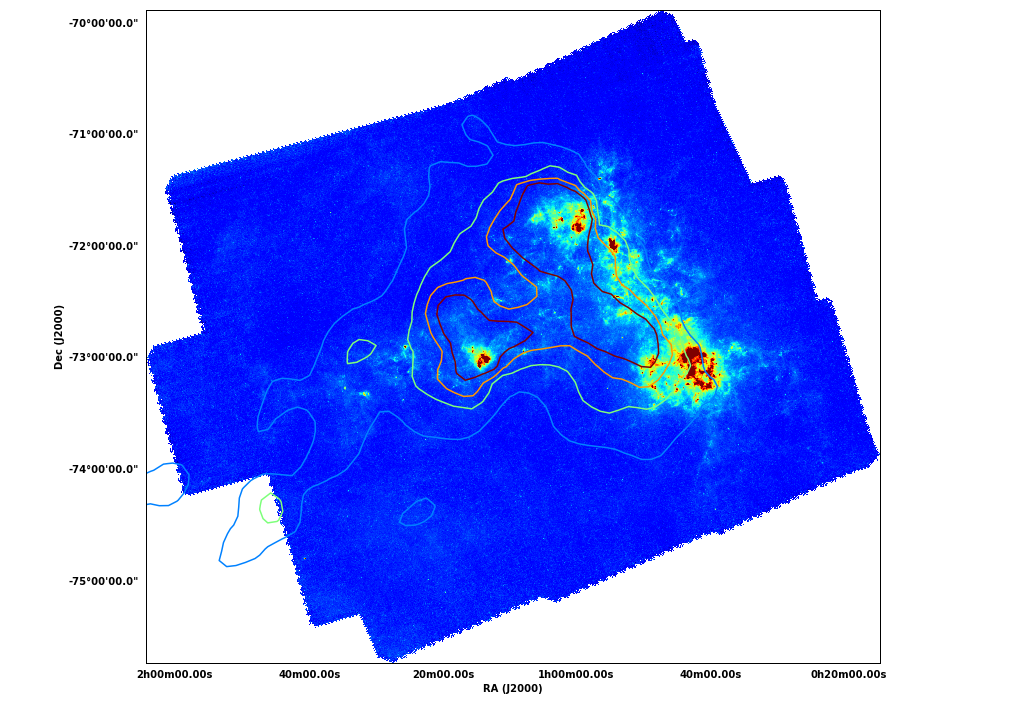

In [56]:
'''
The first statement here is setting up the plotting figure as a 18x12 inches
plot. 

Next we use the APLpy.FITSFigure function to plot the herschel_imagehdu onto 
the figure 'fig'. We then use the F.show_colorscale to show the plot using
the default colorscale. The value of the colors is presented in the 
colorbar on the plot. 

In order to overplot the HI information from the previously downloaded 
datacube we use F.use_contour function. Here we only plot the velocity 
field at index 600. (TODO) The value of the contours of the plot are presented
on the contour lines themselves using the last statement.

'''

fig = plt.figure(figsize = (18,12))

F = aplpy.FITSFigure(herschel_imagehdu, figure = fig)

F.show_colorscale()
F.show_colorbar()
F.show_contour(cube.hdu, slices = [600])


INFO: Auto-setting vmin to -4.660e+00 [aplpy.core]
INFO: Auto-setting vmax to  5.058e+01 [aplpy.core]


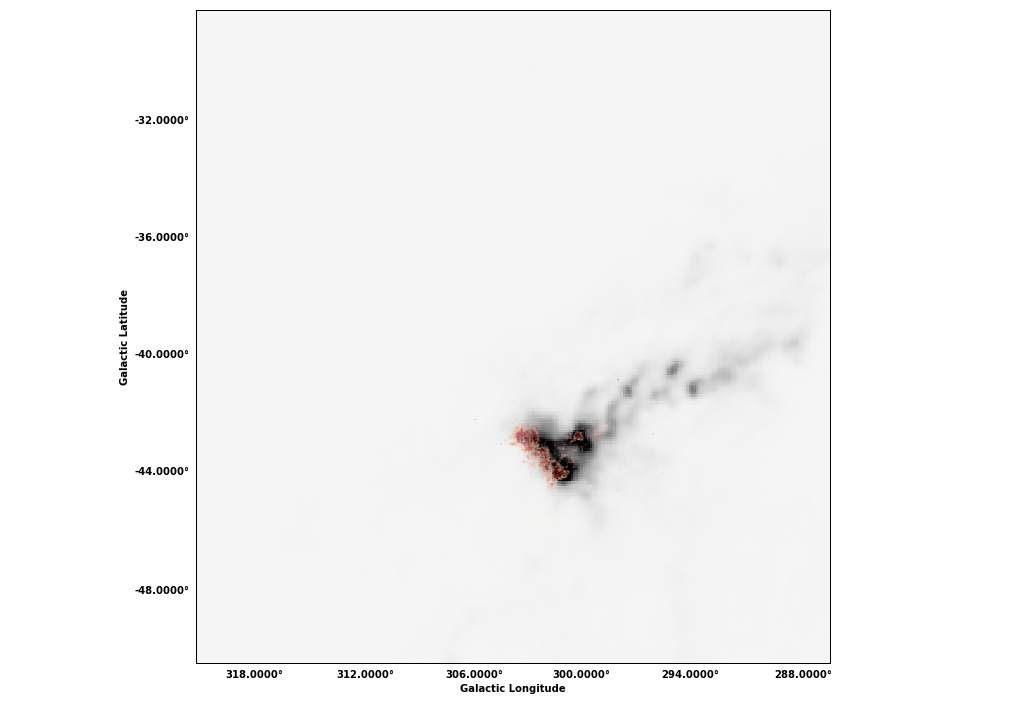

In [55]:
def find_nannearest_idx(array,value):
    idx = np.nanargmin(np.abs(array-value))
    return idx

lat_range = [-46, -40]
lon_range = [306, 295]

# Find lattitude index values
_, b, _ = cube.world[0,:,0] #extract latitude world coordinates from cube
_, _, l = cube.world[0,0,:] #extract longitude world coordinates from cube
b = b.value
l = l.value
lat_range_idx = sorted([find_nannearest_idx(b, lat_range[0]), find_nannearest_idx(b, lat_range[1])])
lon_range_idx = sorted([find_nannearest_idx(l, lon_range[0]), find_nannearest_idx(l, lon_range[1])])


# Create a sub_cube cut to these coordinates and convert to km/s
sub_cube = cube[:,lat_range_idx[0]:lat_range_idx[1], lon_range_idx[0]:lon_range_idx[1]].with_spectral_unit(u.km / u.s)

sub_cube_m0 = sub_cube.moment(order = 0)

In [ ]:
fig = plt.figure(figsize = (18,12))

F = aplpy.FITSFigure(sub_cube_m0.hdu, figure = fig)

F.show_colorscale(cmap = 'YlGnBu_r', aspect = 'auto', stretch = 'log')
F.show_colorbar(axis_label_text = 'Temperature * Velocity (K km / s)')
F.show_contour(herschel_imagehdu, cmap = 'Reds', alpha = .5)

In [ ]:
result['HERSCHEL'][np.array(ind, dtype='bool')].show_in_notebook()

In [ ]:
images = ESASky.get_maps(astroquery.utils.TableList(result['HERSCHEL'][np.array(ind, dtype='bool')]), 
                         cache = False)

In [ ]:
type(images)

In [ ]:
table = result['HERSCHEL']
print(table)

In [ ]:
test = astroquery.utils.TableList(result['HERSCHEL'][np.array(ind, dtype='bool')])

In [ ]:
test['HERSCHEL'].show_in_notebook()

In [ ]:
test = astroquery.utils.TableList({"HERSCHEL":result['HERSCHEL'][np.array(ind, dtype='bool')]})